## Categories

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

Each line of file `data/category_tree.csv` describes pair of categories. First category is child of the second one. parent category can be missing.

In [196]:
pairs = []
with open("data/category_tree.csv", "r") as file:
    for line in file.readlines()[1:]:
        tokens = line.strip().split(",")
        pairs.append((tokens[0], tokens[1]))

pairs[:10]

[('1016', '213'),
 ('809', '169'),
 ('570', '9'),
 ('1691', '885'),
 ('536', '1691'),
 ('231', ''),
 ('542', '378'),
 ('1146', '542'),
 ('1140', '542'),
 ('1479', '1537')]

In [197]:
categories = set()
for child, parent in pairs:
    categories.add(child)
    categories.add(parent)

len(categories)

1670

There are 1669 categories in the dataset (empty string category is in `categories`, but does not represent any category).

In [198]:
max_cat = int(max(categories, key=lambda x: int(x) if x != "" else 0))
max_cat

1698

The maximum category id is 1698.

Since the maximum category ID is larger than the number of categories in the dataset, I will work with category IDs $[0,$`max_cat`$]$ (and a category with empty string as ID representing root of the category tree).

In [199]:
categories = set([f"{id}" for id in range(max_cat + 1)])
categories.add("")

In [200]:
root = ""
to_process = set([root])
rest = categories - to_process
tree = {category: {} for category in categories}

while len(to_process) > 0:
    category = to_process.pop()
    tree[category]["children"] = set()
    for child, parent in pairs:
        if child == category:
            tree[category]["parent"] = parent
        if parent == category:
            tree[category]["children"].add(child)
            to_process.add(child)

print(tree["1600"])

{'children': {'1302', '1107', '55', '1684', '968', '581', '872', '995', '736', '287'}, 'parent': ''}


`tree` is a dictionary describing category tree. There is a dictionary for every category, which contains set of its children and parent (if the category has a parent).

Item properties are stored in files `data/item_properties_part1.csv` and `data/item_properties_part2.csv`. Each row contains timestamp representing when the item's property changed its value.

All values in the `item_properties` file excluding `categoryid` and `available` properties were hashed. Value of the `categoryid` property contains item category identifier. Value of the `available` property contains availability of the item, i.e. 1 means the item was available, otherwise 0. All numerical values were marked with `n` char at the beginning, and have 3 digits precision after decimal point, e.g., `5` will become `n5.000`, `-3.67584` will become `n-3.675`. All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text `Hello world 2017!` will become `24214 44214 n2017.000`.

-- <cite>https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset</cite>

In [201]:
properties = pd.concat([pd.read_csv("data/item_properties_part1.csv"), pd.read_csv("data/item_properties_part2.csv")])
properties = properties.sort_values("timestamp")
properties[:10]

,timestamp,itemid,property,value
5903679,1431226800000,317951,790,n32880.000
5668945,1431226800000,422842,480,1133979
314220,1431226800000,310185,776,103591
4170323,1431226800000,110973,112,679677
4170324,1431226800000,179597,available,0
8025843,1431226800000,260136,available,1
314210,1431226800000,138592,764,1285872
5668941,1431226800000,216269,364,336749
5668940,1431226800000,299944,764,1285872
5668939,1431226800000,146103,112,679677


In [202]:
properties.dtypes

timestamp     int64
itemid        int64
property     object
value        object
dtype: object

Should I convert itemid to string?

In [203]:
len(properties["itemid"].unique())

417053

There are 417,053 items.

In [204]:
properties[(properties["itemid"] == 317951) & (properties["property"] == "790")]

,timestamp,itemid,property,value
5903679,1431226800000,317951,790,n32880.000
7891519,1431831600000,317951,790,n32880.000
6301247,1432436400000,317951,790,n34560.000
6897599,1433041200000,317951,790,n34560.000
6102463,1433646000000,317951,790,n30000.000
6698815,1434250800000,317951,790,n16920.000
7295167,1435460400000,317951,790,n16920.000
8487871,1436065200000,317951,790,n16800.000
7096383,1436670000000,317951,790,n16920.000
6500031,1437274800000,317951,790,n16920.000


Item's properties change over time - table above describes property 790, which is believed to represent price, since it is the only purely numerical value in the dataset.

-- <cite>https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset/discussion/31717</cite>

In [205]:
item_categories = np.sort(properties[(properties["property"] == "categoryid")]["value"].unique())
len(item_categories)

1242

There are 1242 categories containing at least one item.

In [206]:
properties[(properties["property"] == "categoryid") & (properties["value"] == "181")]

,timestamp,itemid,property,value
8017211,1431226800000,134536,categoryid,181
3889190,1431226800000,453514,categoryid,181
7692011,1431226800000,85044,categoryid,181
4517715,1431831600000,156572,categoryid,181
1342558,1435460400000,176558,categoryid,181


Category `181` is not present in file `data/category_tree.csv`, but some items are assigned to it. This is the reason why I created categories with ID in $[0,$`max_cat`$]$.

In [207]:
properties[(properties["property"] == "categoryid") & (properties["itemid"] == 134536)]

,timestamp,itemid,property,value
8017211,1431226800000,134536,categoryid,181


The `categoryid` property of item `134536` was not changed from `181`, so the category `181` still exists, but is simply not in the tree...

In [208]:
categories = [f"{cat}" for cat in categories]
items_in_categories = {
    category: set() for category in categories
}
for index, row in properties[properties["property"] == "categoryid"].iterrows():
    items_in_categories[row["value"]].add(row["itemid"])


`items_in_categories` is a dictionary containing set of items in each category.

In [209]:
for item in properties["itemid"].unique():
    if len(properties[
            (properties["itemid"] == item) &
            (properties["property"] == "categoryid")
        ]["value"].unique()) > 1:
        print(item)
        break


138592


In [210]:
properties[(properties["property"] == "categoryid") & (properties["itemid"] == 138592)]

,timestamp,itemid,property,value
7886151,1431226800000,138592,categoryid,1613
8681283,1431831600000,138592,categoryid,1613
8084934,1432436400000,138592,categoryid,1613
8482500,1433041200000,138592,categoryid,1613
399295,1433646000000,138592,categoryid,1613
8283717,1434250800000,138592,categoryid,1613
7687368,1435460400000,138592,categoryid,1613
995644,1436065200000,138592,categoryid,1613
8880066,1436670000000,138592,categoryid,1613
1729,1437274800000,138592,categoryid,1613


At least one item (`138592`) changed its category (from `1613` to `491`), so I must create `items_in_categories` differently in order to represent the latest state of dataset.

In [211]:
len(properties["itemid"].unique()) == len(properties[properties["property"] == "categoryid"]["itemid"].unique())

True

Every item has its category set.

In [212]:
items = properties["itemid"].unique()
item_categories = {}
for index, row in properties[properties["property"] == "categoryid"].iterrows():
    item_categories[row["itemid"]] = row["value"]

print(item_categories[138592])

491


`item_categories` contains latest category for each item.

In [213]:
items_in_categories = {
    id: set() for id in categories
}
for item, category in item_categories.items():
    items_in_categories[category].add(item)

items_in_categories["181"]

{85044, 134536, 156572, 176558, 453514}

`items_in_categories` contains set of items in each category.

In [214]:
x = categories
y = [len(items_in_categories[cat]) for cat in x]

`x` contains categories, `y` number of items in categories in the same order. These collections are later used for plotting.

In [215]:
desc = np.argsort(y)[::-1]
max_str = "max:"
for index in desc[:3]:
    max_str += f"\n    {y[index]} (Category {x[index]})"
print(max_str)
print(f"mean:   {np.mean(y)}")

max:
    17231 (Category 342)
    10982 (Category 769)
    10561 (Category 173)
mean:   245.32529411764705


The maximum number of items in a category is 17231, the mean of number of items in a category is 245.614.

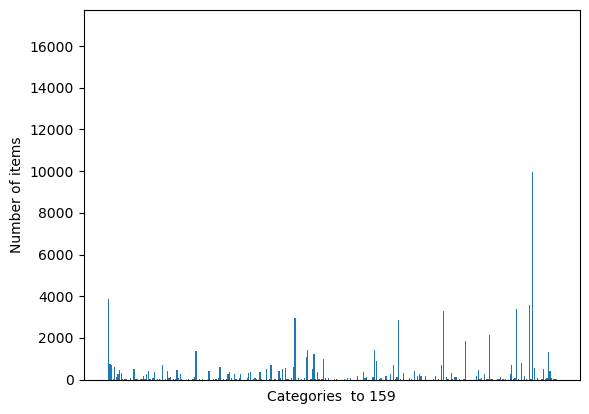

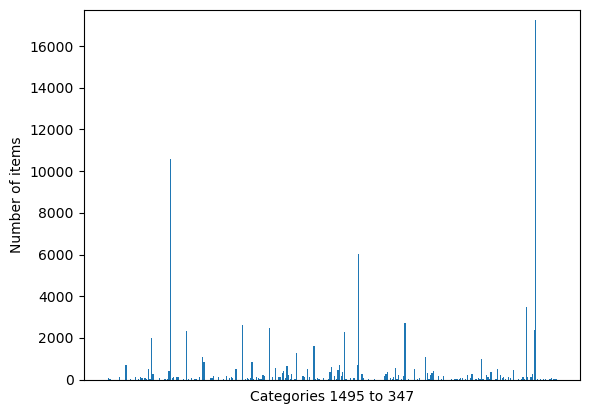

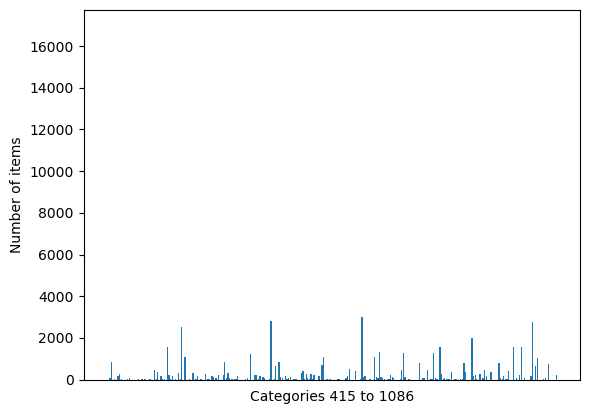

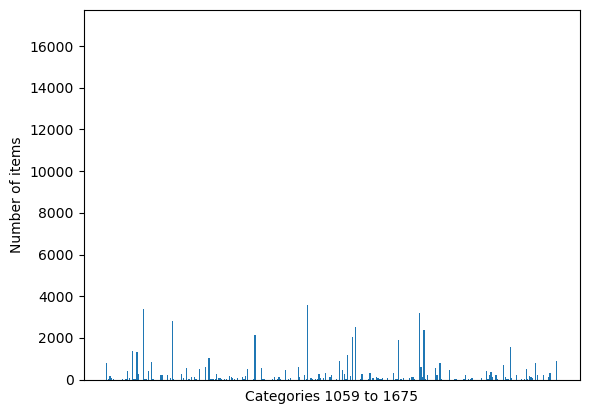

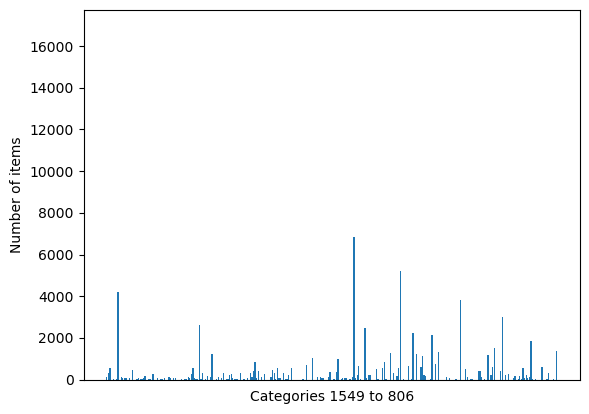

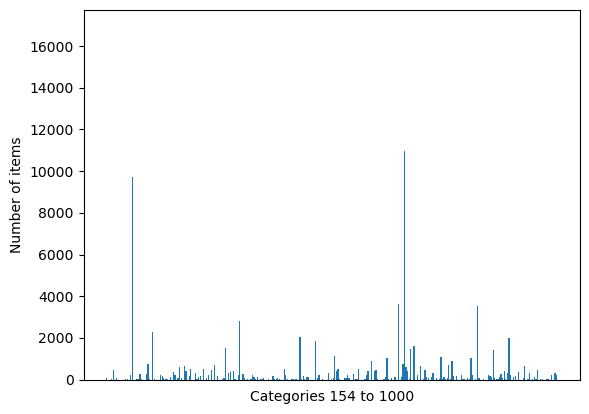

In [216]:
num_parts = 6
part_size = len(x) // num_parts
for part in range(num_parts):
    fig, ax = plt.subplots(1)
    start = part * part_size
    if part == num_parts - 1:
        ax.bar(x[start:], y[start:])
    else:
        ax.bar(x[start : start + part_size], y[start : start + part_size])
    ax.set_xlabel(f"Categories {x[start]} to {x[start + part_size - 1]}")
    ax.set_ylabel("Number of items")
    ax.set_xticks([])
    ax.set_xticklabels([])
    plt.ylim(0, max(y) + 500)
    plt.show()

Plots above show number of items in categories, in order to display bar graphs properly, the categories are split into 6 parts.